In [ ]:
#FeatureSelectionByMultilevelEnrichmentImports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm

sys.path.append('/home/camiel/chromograph/')
import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

import fisher

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import loompy
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [ ]:
from collections import Counter

with loompy.connect(GA = '/proj/DEV_ATAC/Kriegstein_20200711/All/All_GA.loom', 'r') as ds:
    cnt = Counter(ds.ca.Shortname)
    print(cnt)

17:25:38 INFO     Convert to CPMs
17:25:39 INFO     Calculating variance
17:25:49 INFO     Selecting 20000 peaks for clustering


20000


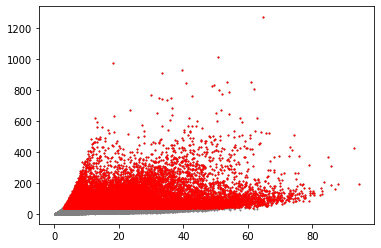

In [20]:
f = '/data/proj/scATAC/chromograph/Kriegstein_20200618/All/All_peaks.loom'
temporary_aggregate = '/data/proj/scATAC/chromograph/Kriegstein_20200618/All/All_peaks_tmp.agg.loom'
N_peaks = 20000

with loompy.connect(f) as ds:   
    ds.aggregate(temporary_aggregate, None, "Clusters", "sum", {"Clusters": "first"})
    with loompy.connect(temporary_aggregate) as dsout:
        ## Normalize peak counts by total fragments per cluster
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)
        logging.info('Calculating variance')
        (mu, sd) = dsout['CPM'].map((np.mean, np.std), axis=0)
        logging.info(f'Selecting {N_peaks} peaks for clustering')
        Valid = sd**2 > np.quantile(sd**2, 1-(N_peaks/ds.shape[0]))
        
    plt.scatter(mu, sd, s=1, c='gray')
    plt.scatter(mu[Valid], sd[Valid], s=1, c='red')
    print(np.sum(Valid))

18:56:15 INFO     Convert to CPMs
18:56:17 INFO     Calculating variance
18:56:26 INFO     Selecting 20000 peaks for clustering
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
18:56:40 INFO     Considering 121855 peaks out of 227433
/home/camiel/anaconda3/envs/chromo/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


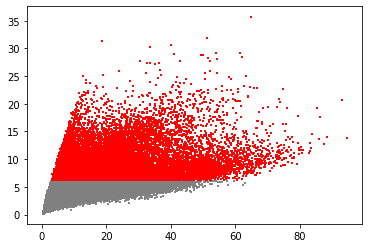

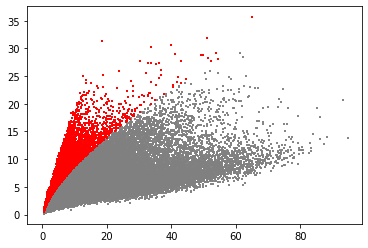

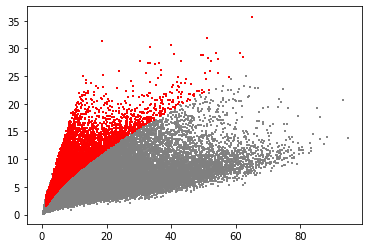

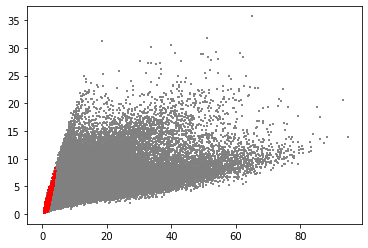

In [83]:
from chromograph.peak_analysis.feature_selection_by_variance import FeatureSelectionByVariance
f = '/data/proj/scATAC/chromograph/Kriegstein_20200618/All/All_peaks.loom'
temporary_aggregate = '/data/proj/scATAC/chromograph/Kriegstein_20200618/All/All_peaks_tmp.agg.loom'
N_peaks = 20000

with loompy.connect(f) as ds:   
#     ds.aggregate(temporary_aggregate, None, "Clusters", "sum", {"Clusters": "first"})
    with loompy.connect(temporary_aggregate) as dsout:
        ## Normalize peak counts by total fragments per cluster
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)
        logging.info('Calculating variance')
        (mu, sd) = dsout['CPM'].map((np.mean, np.std), axis=0)
        logging.info(f'Selecting {N_peaks} peaks for clustering')
        V1 = sd**2 > np.quantile(sd**2, 1-(N_peaks/ds.shape[0]))
        
        ## With no threshold
        if 'Valid' in dsout.ra:
            del dsout.ra.Valid
        fs = FeatureSelectionByVariance(n_genes=20000, layer='CPM')
        V2 = fs.fit(dsout)
        
        ## With threshold
        frac = ds.ra.NCells / ds.shape[1]
        dsout.ra.Valid = frac > 0.01
        logging.info(f'Considering {np.sum(dsout.ra.Valid)} peaks out of {dsout.shape[0]}')
        fs = FeatureSelectionByVariance(n_genes=20000, layer='CPM')
        V3 = fs.fit(dsout)
    
        plt.figure()
        plt.scatter(mu, sd, s=1, c='gray', marker=',')
        plt.scatter(mu[V1], sd[V1], s=1, c='red', marker=',')

        plt.figure()
        plt.scatter(mu, sd, s=1, c='gray', marker=',')
        plt.scatter(mu[V2], sd[V2], s=1, c='red', marker=',')
        
        plt.figure()
        plt.scatter(mu, sd, s=1, c='gray', marker=',')
        plt.scatter(mu[V3], sd[V3], s=1, c='red', marker=',')

        plt.figure()
        plt.scatter(mu, sd, s=1, c='gray', marker=',')
        plt.scatter(mu[np.where(dsout.ra.Valid==0)], sd[np.where(dsout.ra.Valid==0)], s=1, c='red', marker=',')

In [84]:
from scipy.spatial.distance import jaccard

jaccard(V2, V3)

0.5809060914606025

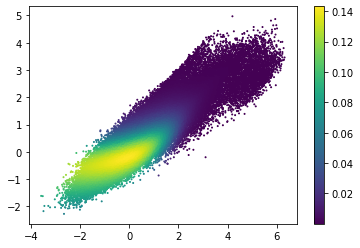

In [78]:
from scipy.stats import gaussian_kde

with loompy.connect(f) as ds:
    # Calculate the point density
    xy = np.vstack([mu[:50000], sd[:50000]])
    z = gaussian_kde(xy)(xy)
    
    ##Plot points
    plt.scatter(np.log2(mu[:50000]), np.log2(sd[:50000]), c=z, s=1)
    plt.colorbar()

#     for x in [2e4, 1e4, 5e3, 2e3]:
#         q = np.quantile(sd**2, 1-(x/ds.shape[0]))
#         plt.axhline(np.sqrt(q))
#         q = np.quantile(mu, 1-(x/ds.shape[0]))
#         plt.axvline(q, c='red')    

In [25]:
from cytograph.decomposition import HPF

with loompy.connect(f) as ds:  
    data = ds[''].sparse(rows=np.array(Vatocood==1)).T
    data = data > 0

bool


In [28]:
hpf = HPF(k=40, validation_fraction=.05, min_iter=10, max_iter=20, compute_X_ppv=False, n_threads=4)
hpf.fit(data.tocoo())

17:35:45 INFO     HPF to 40 factors using 4 threads


HPF (nnz=62,011,482):   0%|          | 0/21 [00:00<?, ?it/s]

/home/camiel/cytograph-dev/cytograph/decomposition/HPF_accel.py:49: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "compute_y_phi_batch" failed type inference due to: No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(bool, 1d, C), Tuple(slice<a:b>, none))
 
There are 16 candidate implementations:
   - Of which 14 did not match due to:
   Overload of function 'getitem': File: <numerous>: Line N/A.
     With argument(s): '(array(bool, 1d, C), Tuple(slice<a:b>, none))':
    No match.
   - Of which 2 did not match due to:
   Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 162.
     With argument(s): '(array(bool, 1d, C), Tuple(slice<a:b>, none))':
    Rejected as the implementation raised a specific error:
      TypeError: unsupported array index type none in Tuple(slice<a:b>, none)
  raised from /home/camiel/anaconda3/envs/chromo/lib/pyt

HPF (nnz=62,011,482):   5%|▍         | 1/21 [02:14<44:51, 134.58s/it, ll=-2.24e+7]

/home/camiel/cytograph-dev/cytograph/decomposition/HPF_accel.py:49: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "compute_y_phi_batch" failed type inference due to: No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(bool, 1d, C), Tuple(slice<a:b>, none))
 
There are 16 candidate implementations:
      - Of which 14 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(array(bool, 1d, C), Tuple(slice<a:b>, none))':
       No match.
      - Of which 2 did not match due to:
      Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 162.
        With argument(s): '(array(bool, 1d, C), Tuple(slice<a:b>, none))':
       Rejected as the implementation raised a specific error:
         TypeError: unsupported array index type none in Tuple(slice<a:b>, none)
  raised from /home/camiel/an

HPF (nnz=62,011,482):   5%|▍         | 1/21 [03:05<1:01:59, 185.96s/it, ll=-2.24e+7]


KeyboardInterrupt: 

In [65]:
fdir = '/data/proj/scATAC/chromograph/Kriegstein_20200618/All/'
f = os.path.join(fdir, 'All_peaks.loom')
out_file = os.path.join(fdir, 'All_peaks.agg.loom')

with loompy.connect(f) as ds:
    with loompy.connect(out_file) as dsout:
        print(dsout.shape)
        x =  dsout['marker_peaks'].map([np.sum], axis=0)[0] > 0
        annot = dsout.ra.Annotation[x]

(227433, 26)


In [45]:
def tmp_plot_peak_annotation_wheel(annotation, out_file=None):
    '''
    Generates a pie chart of the genomic annotations of identified peaks
    
    Args:
        annnotation           Connection to the .loom file to use
        out_file              Name and location of the output file
        
    Remarks:
    
    '''
    simple_annotation = np.array([x.split(' ')[0].lower() for x in annotation['Annotation']])

    counts = {}
    for x in np.unique(simple_annotation):
        counts[x] = np.sum(simple_annotation == x)
        
    labels = 'intergenic', 'intron', 'promoter-tss', 'exon', 'tts'

    for x in labels:
        if x not in counts:
            counts[x] = 0
            
    fig, ax = plt.subplots(figsize = (12,10))
    plt.rcParams["font.size"] = "10"

    size = 0.4
    vals = np.array([counts[x] for x in labels])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(2)*4 + 1)[[1,0],:]
    inner_colors = cmap(np.array([0,1,2,3,4]))[::-1,:]

    ax.pie([vals[0], sum(vals[1:])], radius=1, colors=outer_colors,
           wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(vals.flatten(), radius=1-size, colors=inner_colors, autopct=lambda pct: func(pct, vals), pctdistance=1.2, 
           wedgeprops=dict(width=size, edgecolor='w'), startangle=90)

    ax.set(aspect="equal")
    ax.set_title('Intra- vs. Intergenic Peaks', fontsize=24)

    ax.legend(wedges, labels,
              title="Regions",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    if out_file is not None:
        plt.savefig(out_file)

In [70]:
from chromograph.peak_analysis.feature_selection_by_variance import FeatureSelectionByVariance

with loompy.connect(f) as ds:
    with loompy.connect(out_file) as dsout:
        logging.info(f'Start')
        fs = FeatureSelectionByVariance(n_genes=25000, layer='CPM')
        selected = fs.fit(dsout)
        logging.info(f'Finished')

15:48:15 INFO     Start
15:48:26 INFO     Finished


In [71]:
with loompy.connect(f) as ds:
    with loompy.connect(out_file) as dsout:
        (mu, sd) = dsout['CPM'].map((np.mean, np.std), axis=0)

In [82]:
with loompy.connect('/data/proj/scATAC/chromograph/build_20200623/Cerebellum/Cerebellum_peaks.loom') as ds:

    del ds.ca.HPF_LogPP
    
    print(ds.ca.keys())
    
    print('HPF_LogPP' in ds.ca)
    

['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersModularity_bin', 'ClustersSurprise', 'ClustersSurprise_bin', 'Clusters_bin', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Finalconc', 'GA_colsum', 'HPF', 'HPF_theta', 'Id', 'Idxset', 'Inputmrna', 'Label', 'Method', 'Molarity', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersModularity_bin', 'OutliersSurprise', 'OutliersSurprise_bin', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UMAP', 'U

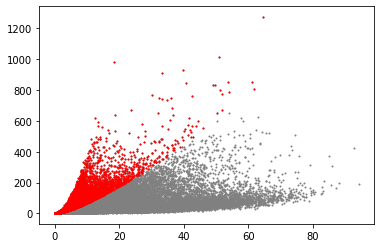

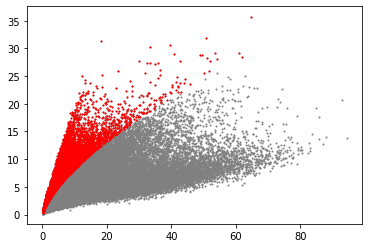

In [73]:
plt.scatter(mu, sd**2, s = 1, c = 'grey')
plt.scatter(mu[selected], sd[selected]**2, s = 1, c = 'red')

plt.figure()
plt.scatter(mu, sd, s = 1, c = 'grey')
plt.scatter(mu[selected], sd[selected], s = 1, c = 'red')

(array([0.17341455, 0.78568685, 1.23456133, 1.52504634, 1.54132352,
        1.49186594, 1.34098903, 1.20388511, 1.05676446, 0.92967727,
        0.8057203 , 0.63418389, 0.5265041 , 0.39440854, 0.30989242,
        0.23852326, 0.21661167, 0.18217918, 0.17091037, 0.14712064,
        0.13647787, 0.1396081 , 0.13397369, 0.1202007 , 0.08827239,
        0.05884826, 0.03944085, 0.01690322, 0.00626045, 0.00187814]),
 array([0.05578815, 0.11968129, 0.18357443, 0.24746757, 0.31136071,
        0.37525385, 0.43914699, 0.50304013, 0.56693327, 0.63082641,
        0.69471955, 0.75861269, 0.82250583, 0.88639897, 0.95029211,
        1.01418525, 1.07807839, 1.14197153, 1.20586467, 1.26975782,
        1.33365096, 1.3975441 , 1.46143724, 1.52533038, 1.58922352,
        1.65311666, 1.7170098 , 1.78090294, 1.84479608, 1.90868922,
        1.97258236]),
 <a list of 30 Patch objects>)

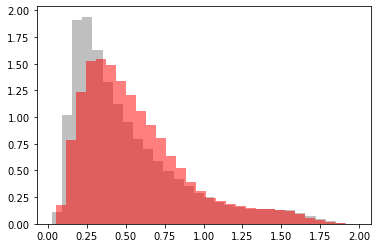

In [59]:
plt.hist(np.log10(mu+1), bins = 30, color='grey', alpha=.5, density=True)
plt.hist(np.log10(mu[selected]+1), bins = 30, color='red', alpha=.5, density=True)

In [29]:
with loompy.connect(f) as ds:
    with loompy.connect(out_file) as dsout:
        print(dsout['q_val'][:,:])

[[0.93054177 1.         0.52164035 ... 1.         1.         1.        ]
 [1.         1.         0.73542964 ... 1.         1.         1.        ]
 [0.92675643 1.         0.36503896 ... 1.         1.         1.        ]
 ...
 [0.65312351 1.         0.74275197 ... 1.         1.         1.        ]
 [0.42117816 1.         1.         ... 1.         1.         1.        ]
 [0.70920214 1.         1.         ... 1.         1.         1.        ]]


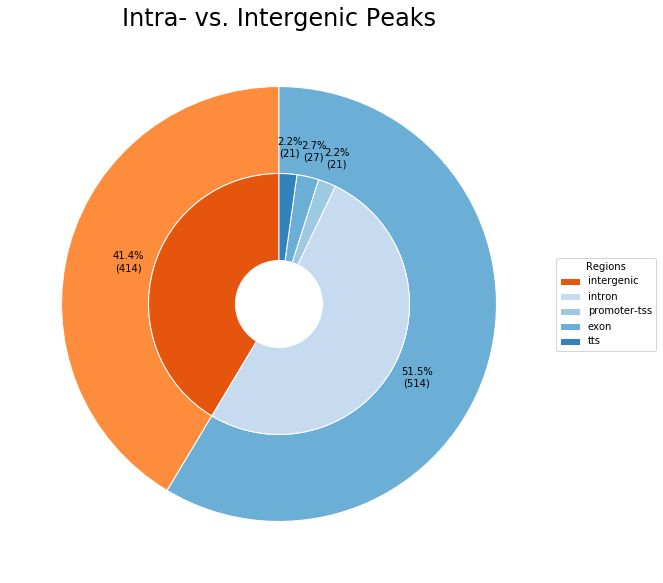

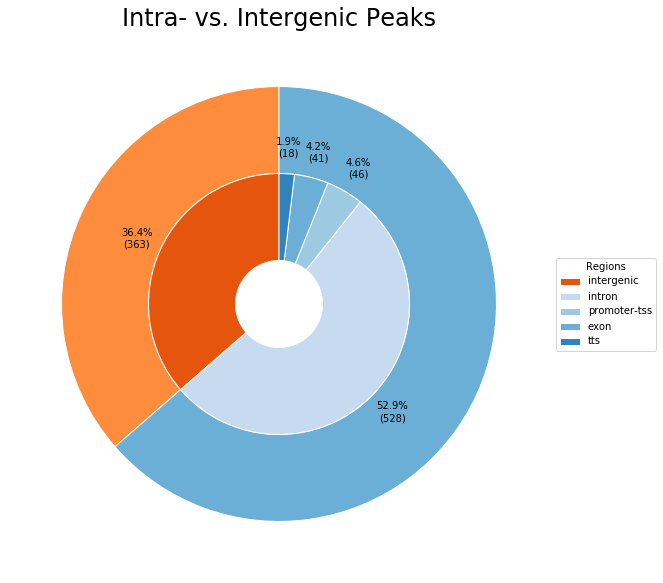

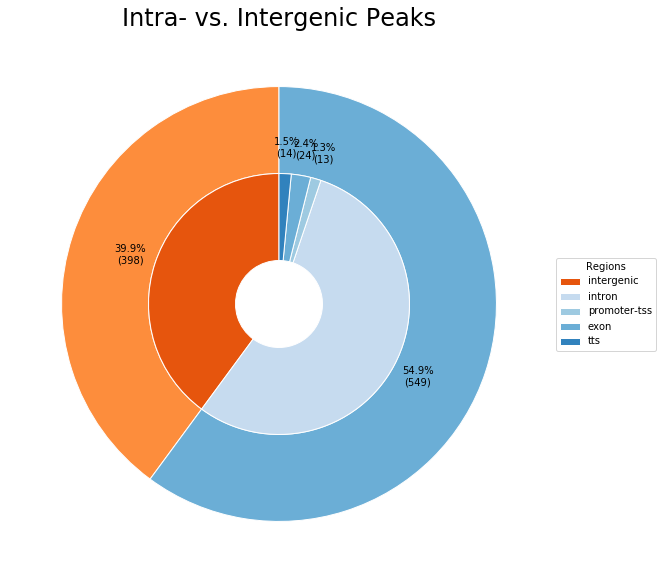

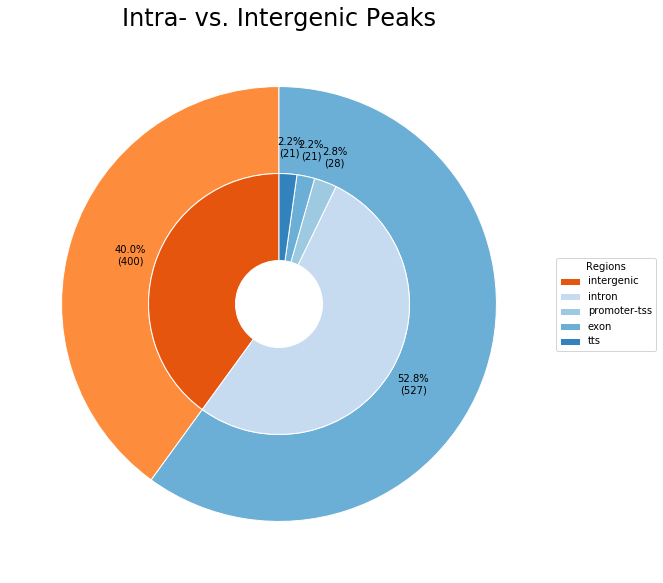

In [11]:
with loompy.connect(f) as ds:
    with loompy.connect(out_file) as dsout:
        for x in [16, 19, 22, 5]:
            annot = dsout.ra.Annotation[dsout.layers['marker_peaks'][:,x]==1]
            tmp_plot_peak_annotation_wheel({'Annotation': annot}, f'/home/camiel/misc/cluster{x}_peak_annotation.png')
#             plt.title(f'{x}')

In [149]:
from statsmodels.sandbox.stats.multicomp import multipletests
import fisher

def FisherDifferentialPeaks(ds: loompy.LoomConnection, sig_thres: float = 0.05, mtc_method: str = 'fdr_bh'):
    '''
    Performs Fisher-exact test to identify differentially accessible peaks via one-versus all testing.
    
    Args:
        ds             LoomConnection (aggregated peak file)
        sig_thres      Adjusted significance threshold
        mtc_method     Multiple test correction method. Accepts all methods from statsmodels multipletests
       
    Returns
        enrichment     Numpy array containing odds ratios
        q-values       Numpy array containing adjusted p-values
    '''
    enrichment = np.zeros(ds.shape)
    q_values = np.zeros(ds.shape)
    Total = np.sum(ds.ca.NCells)
    
    logging.info(f'Performing Fisher exact tests')
    for label in tqdm(ds.ca.Clusters):
        n_cells = ds.ca.NCells[ds.ca.Clusters == label]

        c = np.zeros((ds.shape[0],4))
        c[:,0] = np.array(ds[:,ds.ca.Clusters==label]).astype('int').flatten()
        c[:,1] = ds.ra.NCells - c[:,0]
        c[:,2] = n_cells - c[:,0]
        c[:,3] = Total - n_cells - c[:,1]
        c = c.astype(np.uint)

        _, p, _ = fisher.pvalue_npy(c[:, 0], c[:, 1], c[:, 2], c[:, 3])
        odds = div0(c[:, 0] * c[:, 3], c[:, 1] * c[:, 2])

        _ , q, _, _ =  multipletests(p, sig_thres, method=mtc_method)

        enrichment[:,ds.ca.Clusters == label] = odds.reshape((ds.shape[0],1))
        q_values[:,ds.ca.Clusters == label] = np.array(q).reshape((ds.shape[0],1))

    return enrichment, q_values

In [155]:
from kneed import KneeLocator

def KneeBinarization(dsagg: loompy.LoomConnection, bins: int = 200):
    '''
    Identifies positive peaks for every cluster based on the decay curve of the CPM values
    
    Args:
        ds        LoomConnection to aggregated peak file
        bins      Number of bins to fit CPM scores into. Defaults to 200. User lower number for small cell counts.
                  High values can cause rougher curves.
    Returns:
        peaks       Numpy array of positive peaks
        CPM_thres   Thresholds used for peak binarization in cluster
    '''
    logging.info(f'Binarize peak matrix')
    ## Create layer
    peaks = np.zeros(dsagg.shape)
    CPM_thres = np.zeros(dsagg.shape[1])

    for cls in tqdm(dsagg.ca.Clusters):
        vals = dsagg['CPM'][:,dsagg.ca.Clusters==cls]
        values, base = np.histogram(vals, bins = bins)
        cumulative = np.cumsum(values)

        x = base[:-1]
        y = len(vals)-cumulative

        kn = KneeLocator(x, y, curve='convex', direction='decreasing', interp_method='polynomial')
 
        CPM_thres[dsagg.ca.Clusters==cls] = kn.knee
        valid = vals > kn.knee
        peaks[:,dsagg.ca.Clusters==cls] = valid
    return peaks, CPM_thres

In [3]:
fdir = '/data/proj/scATAC/chromograph/build_20200426/All'
f = os.path.join(fdir, 'All_peaks.loom')
out_file = os.path.join(fdir, 'All_peaks.agg.loom')

agg_spec = {
    "Age": "tally",
    "Clusters": "first",
    "Class": "mode",
    "Total": "mean",
    "Sex": "tally",
    "Tissue": "tally",
    "SampleID": "tally",
    "TissuePool": "first",
    "Outliers": "mean",
    "PCW": "mean"
}

In [ ]:
with loompy.connect(f) as ds:
    cells = ds.col_attrs["Clusters"] >= 0
    labels = ds.col_attrs["Clusters"][cells]
    n_labels = len(set(labels))
    Total = np.sum(cells)
    
    logging.info("Aggregating clusters")
#     ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:
        logging.info('Calculate coverag metrics')
        dsout.ca.NCells = np.bincount(labels, minlength=n_labels)
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Perform fisher exact for peak counts
        dsout['enrichment'], dsout['q_val'] = FisherDifferentialPeaks(dsout)
        
        ## Select top N enriched peaks per cluster by odss-ratio
        dsout['marker_peaks'] = 'int8'
        for i in range(dsout.shape[1]):
            idx = np.sort(dsout['q_val'][:,i].argsort()[:1000])
            dsout['marker_peaks'][idx,i] = 1

17:28:43 INFO     Aggregating clusters
17:28:43 INFO     Calculate coverag metrics
17:28:50 INFO     Convert to CPMs
17:29:18 INFO     Performing Fisher exact tests
 64%|██████▍   | 62/97 [41:24<08:24, 14.41s/it]  

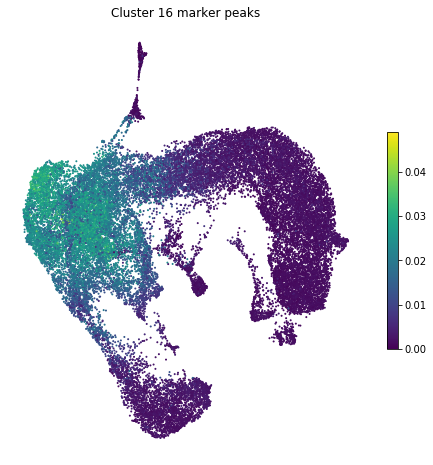

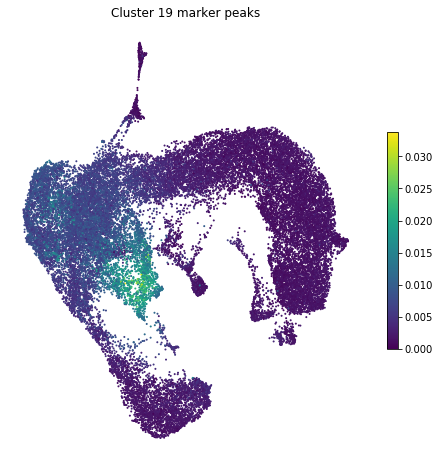

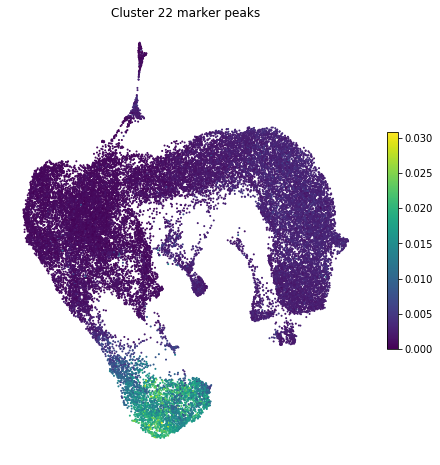

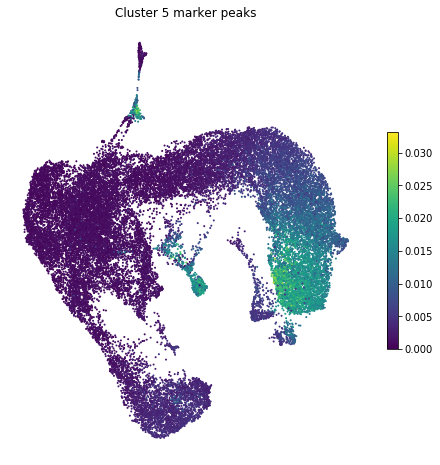

In [15]:
fdir = '/data/proj/scATAC/chromograph/build_20200623/Cerebellum'
f = os.path.join(fdir, 'Cerebellum_peaks.loom')
out_file = os.path.join(fdir, 'Cerebellum_peaks.agg.loom')

with loompy.connect(f) as ds:
    with loompy.connect(out_file) as dsout:
        for i in [16, 19, 22, 5]:
            markers = dsout['marker_peaks'][:,i] > 0
            vals = np.zeros(ds.shape[1])
            for (_, selection, view) in ds.scan(axis=1):
                    vals[selection] = np.sum(view[markers,:], axis = 0)
            vals = vals / ds.ca.NPeaks        
            plt.figure(figsize=(8,8))
            plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=vals, s = 1)
            plt.colorbar(orientation='vertical', shrink=.5)
            plt.axis("off")
            plt.title(f'Cluster {i} marker peaks')
            plt.savefig(f'/home/camiel/misc/cluster{i}_enriched_peaks.png')

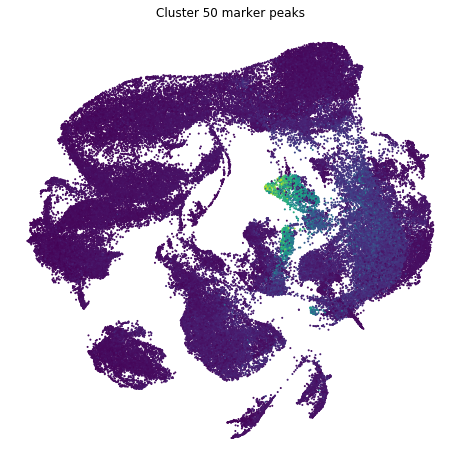

In [273]:
with loompy.connect(f) as ds:
    plt.figure(figsize=(8,8))
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=vals, s = 1)
    plt.axis("off")
    plt.title(f'Cluster 50 marker peaks')








0it [00:00, ?it/s]





20480it [04:02, 127.11it/s]






512it [00:15, 32.50it/s]






1024it [00:18, 43.35it/s]






1536it [00:20, 56.56it/s]






2048it [00:23, 72.33it/s]






2560it [00:25, 89.85it/s]






3072it [00:28, 108.34it/s]






3584it [00:30, 129.72it/s]






4096it [00:32, 149.26it/s]






4608it [00:34, 167.80it/s]






5120it [00:37, 182.14it/s]






5632it [00:39, 196.00it/s]






6144it [00:41, 202.52it/s]






6656it [00:43, 208.95it/s]






7168it [00:46, 217.00it/s]






7680it [00:48, 223.85it/s]






8192it [00:50, 229.35it/s]






8704it [00:52, 235.45it/s]






9216it [00:54, 240.06it/s]






9728it [00:56, 237.97it/s]






10240it [00:58, 245.81it/s]






10752it [01:00, 252.82it/s]






11264it [01:02, 245.09it/s]






11776it [01:05, 220.48it/s]






12288it [01:07, 224.66it/s]






12800it [01:09, 226.89it/s]






13312it [01:12, 227.92it/s]






13824it [01:14, 232.51it/s]






14336it [01:16, 238.41it/s]






14848it 

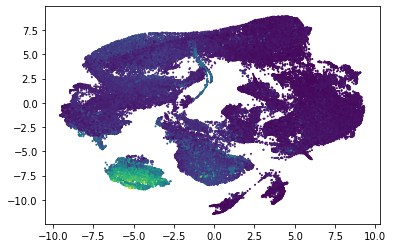








92672it [07:49, 327.94it/s]

In [268]:
# fdir = '/data/proj/scATAC/chromograph/build_20200511'

# Filelist = [os.path.join(fdir, name, f'{name}_peaks.agg.loom') for name in ['All', 'Midbrain', 'Cerebellum', 'Hindbrain']]
fdir = '/data/proj/scATAC/chromograph/build_20200511/All'
f = os.path.join(fdir, 'All_peaks.loom')
out_file = os.path.join(fdir, 'All_peaks.agg.loom')

with loompy.connect(f) as ds:
    with loompy.connect(out_file) as dsout:
        for i in [21]:
            markers = dsout['marker_peaks'][:,i] > 0
            vals = np.zeros(ds.shape[1])
            progress = tqdm(ds.shape[1])
            for (_, selection, view) in ds.scan(axis=1):
                    vals[selection] = np.sum(view[markers,:], axis = 0)
                    progress.update(512)
            vals = vals / ds.ca.NPeaks        
            plt.figure()
            plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=vals, s = 1)

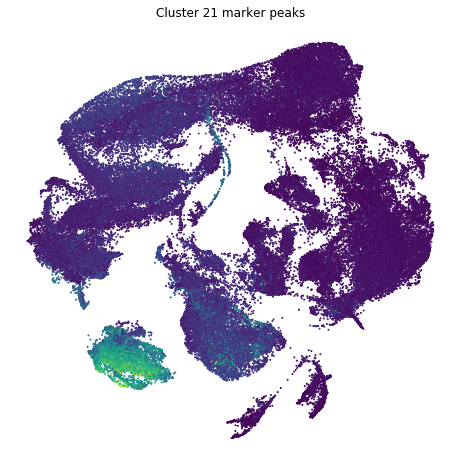

In [269]:
with loompy.connect(f) as ds:
    plt.figure(figsize=(8,8))
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=vals, s = 1)
    plt.axis("off")
    plt.title(f'Cluster 21 marker peaks')

In [226]:
mat = np.array([[0,1,1],
                [1,0,2]])
np.sum(mat,axis=0)

array([1, 1, 3])

In [283]:
with loompy.connect(f) as ds:
    print(ds.layers.keys())
    print(ds.ca.keys())
    print(ds.shape)

['']
['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Finalconc', 'GA_colsum', 'Id', 'Idxset', 'Inputmrna', 'Label', 'Method', 'Molarity', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UMAP', 'UMAP3D', 'barcode', 'blacklist_region_fragments', 'cell_id', 'chimeric', 'duplicate', 'enhancer_region_fragments', 'is__cell_barcode', 'lowmapq'

In [144]:
with loompy.connect(out_file) as dsout:
    ## Select top N enriched peaks per cluster
    dsout['marker_peaks'] = 'int8'
    for i in range(dsout.shape[1]):
        idx = np.sort(dsout['enrichment'][:,i].argsort()[::-1][:1000])
        dsout['marker_peaks'][idx,i] = 1

(array([764., 174.,  42.,   9.,   5.,   1.,   3.,   0.,   0.,   2.]),
 array([0.06520214, 0.76413698, 1.46307183, 2.16200668, 2.86094153,
        3.55987638, 4.25881123, 4.95774607, 5.65668092, 6.35561577,
        7.05455062]),
 <a list of 10 Patch objects>)

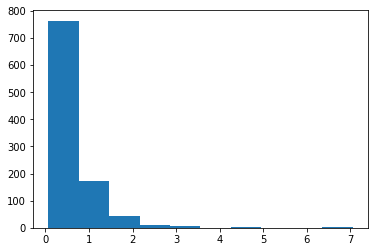

In [147]:
with loompy.connect(out_file) as dsout:
    idx = dsout['marker_peaks'][:,0]
    data = dsout['CPM'][idx==1,:]
    score = np.mean(data, axis=1)
plt.hist(score)

In [182]:
from scipy.spatial.distance import pdist, jaccard, squareform
with loompy.connect(out_file) as dsout:
    res = 1 - pdist(dsout['binary'][:,:].T, metric='jaccard')
    mat = squareform(res)
    
plt.imshow(mat)
plt.figure()
plt.imshow(np.log10(mat+1))

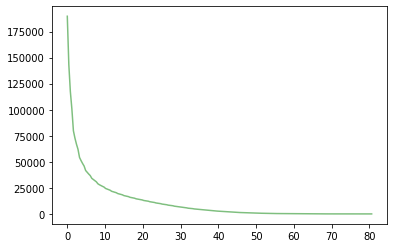

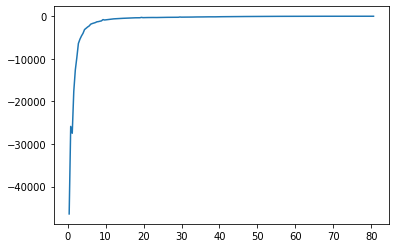

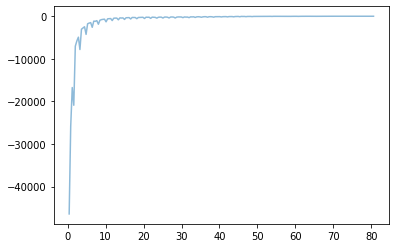

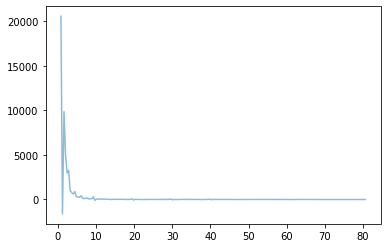

In [80]:
with loompy.connect(out_file) as dsout:
    bins=200
    
    vals = dsout['CPM'][:,0]
    values, base = np.histogram(vals, bins = bins)
    cumulative = np.cumsum(values)
    
    x = base[:-1]
    y = len(vals)-cumulative
    
    plt.figure()
    plt.plot(x, y, c='green', alpha=.5)
    
    ## Get 
    d1 = [y[i]-y[i-1] for i in range(1,len(y),1)]
    
    win = 2
    smooth = [d1[:win]]
    smooth.append([np.mean(d1[i-win:i+win]) for i in range(win, len(d1)-win)])
    smooth.append([0]*win)
    smooth = [item for sublist in smooth for item in sublist]
    
    plt.figure()
    plt.plot(x[1:], smooth)

    d2 = [smooth[i]-smooth[i-1] for i in range(1,len(smooth),1)]
    
    plt.figure()
    plt.plot(x[1:], d1, alpha=.5)
    
    plt.figure()
    plt.plot(x[2:], d2, alpha=.5)
    

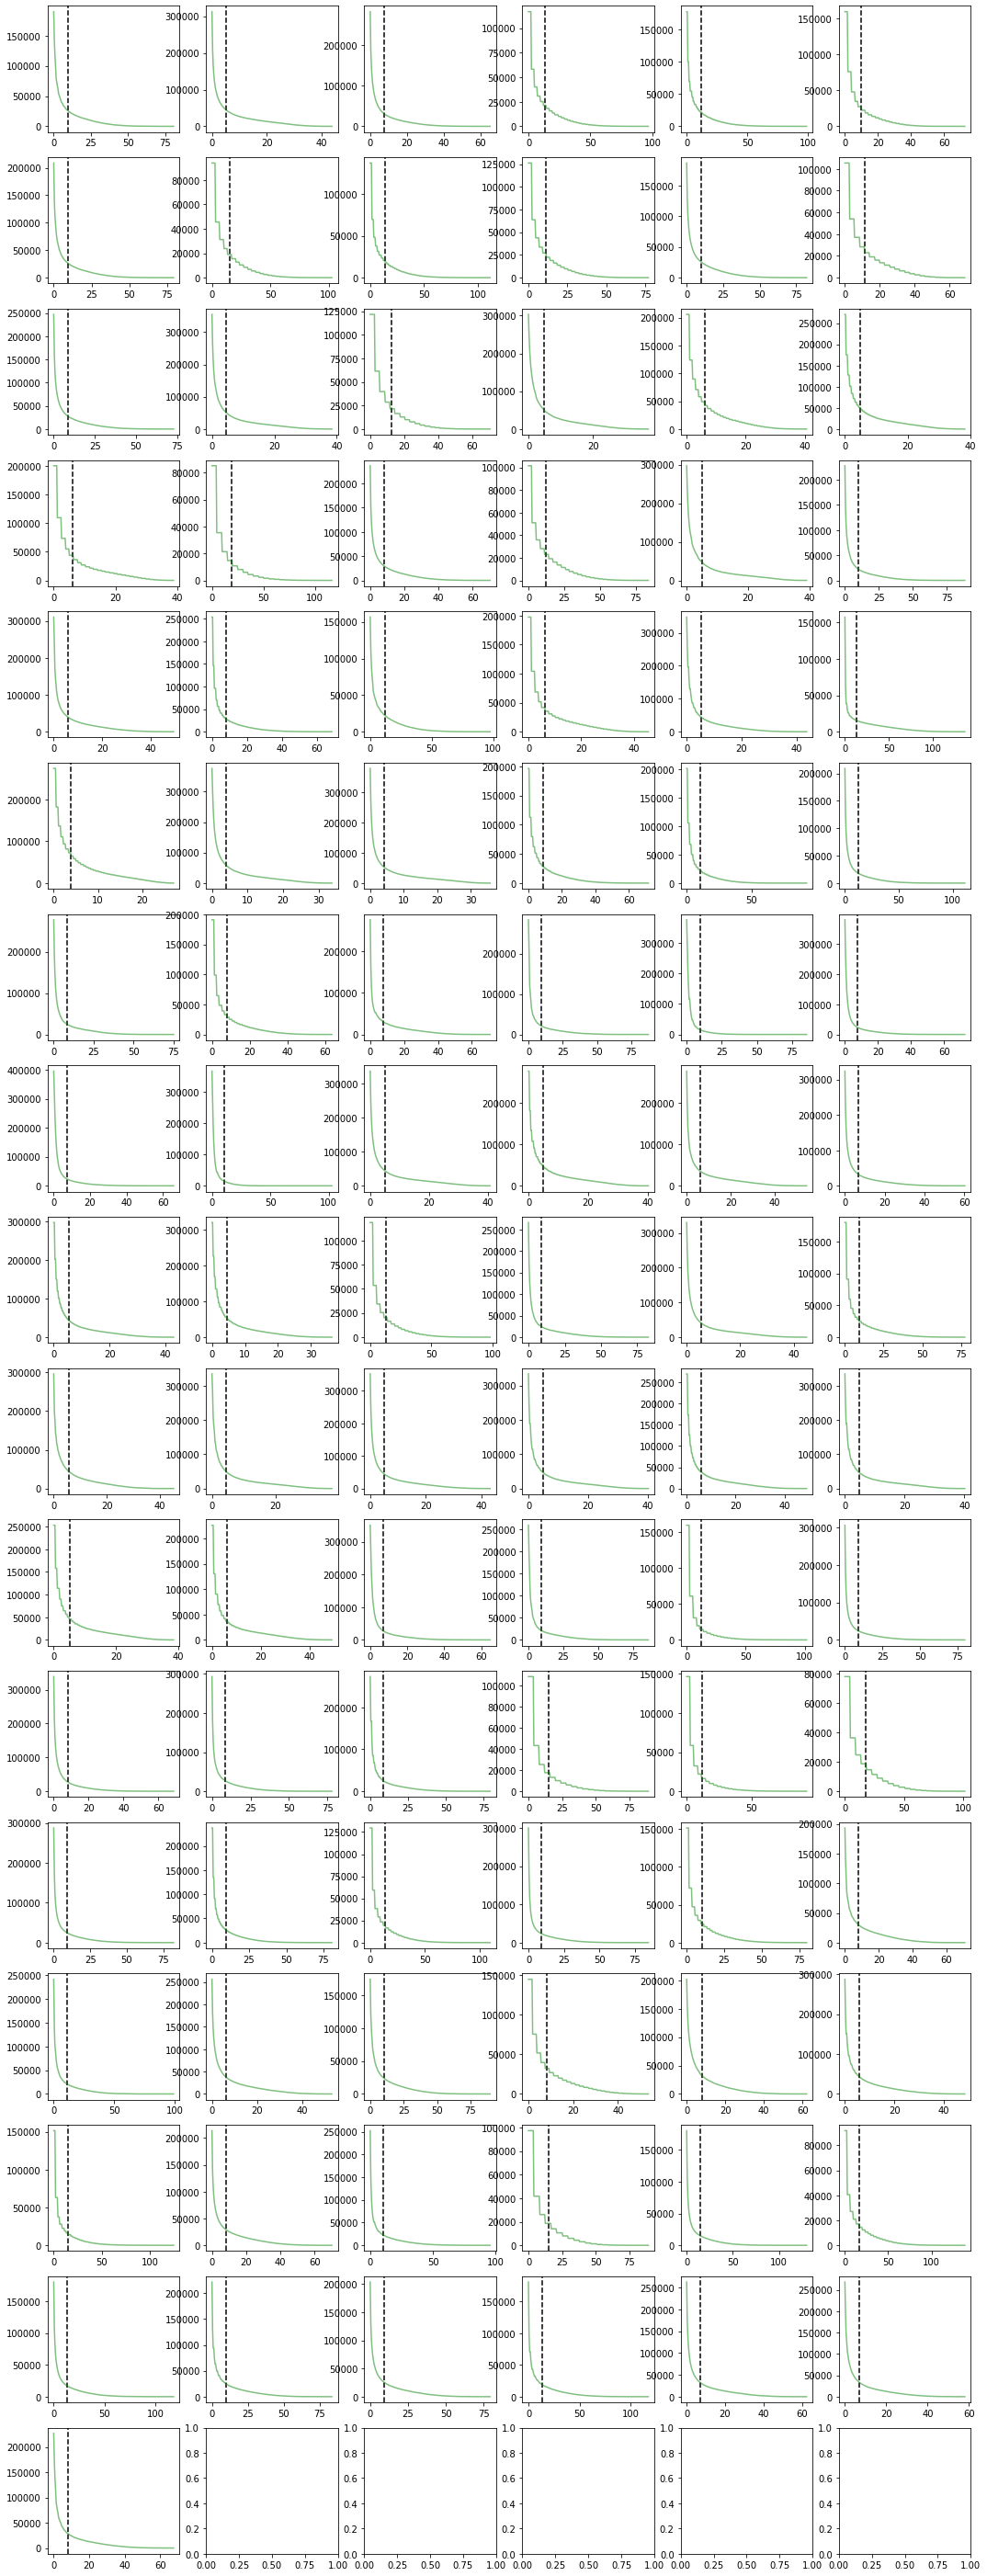

In [123]:
from kneed import KneeLocator

with loompy.connect(out_file) as dsout:
    
    rows = np.ceil(dsout.shape[1]/6).astype(int)
    fig, ax = plt.subplots(rows, 6, figsize=(18, 3*rows))
    ax = ax.flatten()
    
    npeaks = []
    knees = []
    
    dsout.layers['binary'] = 'int8'
    dsout.ca['CPM_thres'] = np.zeros(dsout.shape[1])
    
    for cls in dsout.ca.Clusters:
        bins=200

        vals = dsout['CPM'][:,dsout.ca.Clusters==cls]
        values, base = np.histogram(vals, bins = bins)
        cumulative = np.cumsum(values)

        x = base[:-1]
        y = len(vals)-cumulative

        kn = KneeLocator(x, y, curve='convex', direction='decreasing', interp_method='polynomial')
        ax[cls].plot(x, y, c='green', alpha=.5)
        ax[cls].vlines(kn.knee, 0, 1, transform=ax[cls].get_xaxis_transform(), linestyles='dashed')

        dsout.ca['CPM_thres'][dsout.ca.Clusters==cls] = kn.knee
        valid = vals > kn.knee
        dsout['binary'][:,dsout.ca.Clusters==cls] = valid
        nvalid = np.sum(valid)
        
        knees.append(kn.knee)
        npeaks.append(nvalid)

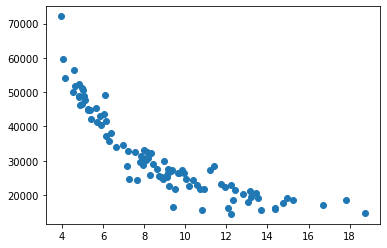

In [109]:
plt.scatter(knees, npeaks)

In [ ]:
import scipy.spatial.distance.jaccard as jaccard

dists = []
for i in n_labels:
    dists.append(jaccard())

In [282]:
#Imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import loompy

sys.path.append('/home/camiel/chromograph/')
from chromograph.pipeline import config

import loompy
from typing import *

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

class Peak_Aggregator:
    def __init__(self) -> None:
        '''
        Aggregate the Gene-Accessibility signal, find markers and call the auto-annotater
        '''
        self.config = config.load_config() # Generic config, just to get the paths

    def fit(self, ds: loompy.LoomConnection, out_file: str, agg_spec: Dict[str, str] = None) -> None:
        '''
        Aggregate the Gene-Accessibility signal, find markers and call the auto-annotater
        
        Args:
            ds              LoomConnection. Dataset must contain ds.ra.Gene and ds.ca.Clusters
            outfile         Filename of aggregation file
            agg_spec        Dictionary containing numpy-groupies function to be applied to column attributes
        '''
        self.outdir = '/' + os.path.join(*out_file.split('/')[:-1], 'exported')

        agg_spec = {
            "Age": "tally",
            "Clusters": "first",
            "Class": "mode",
            "Total": "mean",
            "Sex": "tally",
            "Tissue": "tally",
            "SampleID": "tally",
            "TissuePool": "first",
            "Outliers": "mean",
            "PCW": "mean"
        }
        cells = ds.col_attrs["Clusters"] >= 0
        labels = ds.col_attrs["Clusters"][cells]
        labels = ds.col_attrs["Age"][cells]
        n_labels = len(set(labels))

        logging.info("Aggregating clusters")
        ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
        with loompy.connect(out_file) as dsout:

            if n_labels <= 1:
                return

            logging.info('Calculate coverag metrics')
            dsout.ca.NCells = np.bincount(labels, minlength=n_labels)
            dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
            dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

            ## Normalize peak counts by total fragments per cluster
            logging.info('Convert to CPMs')
            dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

            ## Call positive and negative peaks for every cluster
            dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)
            
            ## Perform fisher exact for peak counts
            dsout['enrichment'], dsout['q_val'] = FisherDifferentialPeaks(dsout)

            ## Select top N enriched peaks per cluster by odss-ratio
            dsout['marker_peaks'] = 'int8'
            for i in range(dsout.shape[1]):
                idx = np.sort(dsout['enrichment'][:,i].argsort()[::-1][:1000])
                dsout['marker_peaks'][idx,i] = 1
            dsout.ra.markerPeaks = dsout.map([np.nonzero], axis=0)[0] > 0
